# Credit Card Fraud Detection using Machine Learning

### Import libraries

In [1]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, Activation, Input
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Import dataset (https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [2]:
df = pd.read_csv('../creditcard.csv')
df = df.dropna()
df = df.drop('Time', axis = 1)

### Investigate Class Sizes

In [3]:
groups = df.groupby('Class')

fraud = (groups.get_group(1).shape[0] / df.shape[0]) * 100
non_fraud = (groups.get_group(0).shape[0] / df.shape[0]) * 100

print('Percent Fraud: ' + str(fraud) + '%')
print('Percent Not Fraud ' + str(non_fraud) + '%')

Percent Fraud: 0.1727485630620034%
Percent Not Fraud 99.82725143693798%


### Split data into a train and holdout set

In [4]:
df_size = df.shape[0]
test_size = int(df_size * .3)
train_size = df_size - test_size

train_df = df.head(train_size)
test_df = df.tail(test_size)

X_train = train_df.drop('Class', axis = 1)
Y_train = train_df['Class']
X_test = test_df.drop('Class', axis = 1)
Y_test = test_df['Class']

### Apply a standard scalar to our data 

In [5]:
for feat in X_train.columns.values:
    ss = StandardScaler()
    X_train[feat] = ss.fit_transform(X_train[feat].values.reshape(-1,1))
    X_test[feat] = ss.transform(X_test[feat].values.reshape(-1,1))

### Fit Random Forest Classifier

In [6]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

probabilities = rf.predict_proba(X_test)
y_pred_rf = probabilities[:,1]

### Evaluate Performance

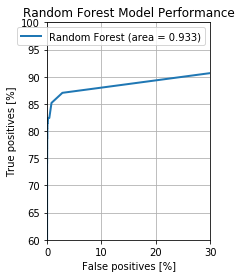

In [7]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(100*fpr_rf, 100*tpr_rf, label= 'Random Forest (area = {:.3f})'.format(auc_rf), linewidth=2, color = colors[0])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Random Forest Model Performance')
plt.legend(loc='best')

### Fit CatBoost Classifier

In [8]:
cat = CatBoostClassifier()
cat.fit(X_train, Y_train)
y_pred_cat = cat.predict(X_test, prediction_type='RawFormulaVal')

Learning rate set to 0.098829
0:	learn: 0.3988961	total: 106ms	remaining: 1m 45s
1:	learn: 0.2094636	total: 136ms	remaining: 1m 7s
2:	learn: 0.1171002	total: 164ms	remaining: 54.4s
3:	learn: 0.0679304	total: 200ms	remaining: 49.8s
4:	learn: 0.0426787	total: 229ms	remaining: 45.6s
5:	learn: 0.0271483	total: 257ms	remaining: 42.6s
6:	learn: 0.0175209	total: 285ms	remaining: 40.4s
7:	learn: 0.0125302	total: 312ms	remaining: 38.7s
8:	learn: 0.0094323	total: 340ms	remaining: 37.5s
9:	learn: 0.0074970	total: 368ms	remaining: 36.5s
10:	learn: 0.0061262	total: 408ms	remaining: 36.7s
11:	learn: 0.0051979	total: 445ms	remaining: 36.6s
12:	learn: 0.0045071	total: 473ms	remaining: 35.9s
13:	learn: 0.0040256	total: 506ms	remaining: 35.6s
14:	learn: 0.0037451	total: 541ms	remaining: 35.5s
15:	learn: 0.0034942	total: 571ms	remaining: 35.1s
16:	learn: 0.0033005	total: 602ms	remaining: 34.8s
17:	learn: 0.0031545	total: 636ms	remaining: 34.7s
18:	learn: 0.0030185	total: 664ms	remaining: 34.3s
19:	learn:

### Evaluate performacne

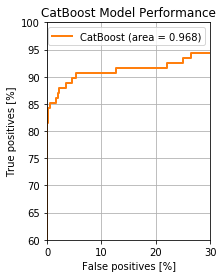

In [9]:
fpr_cat, tpr_cat, thresholds_cat = roc_curve(Y_test, y_pred_cat)
auc_cat = auc(fpr_cat, tpr_cat)

plt.plot(100*fpr_cat, 100*tpr_cat, label= 'CatBoost (area = {:.3f})'.format(auc_cat), linewidth=2, color = colors[1])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('CatBoost Model Performance')
plt.legend(loc='best')

### Design and fit Deep Neural Network

In [10]:
#Design and compile model
DNN = Sequential()
DNN.add(Input(shape=(X_train.shape[1],)))
DNN.add(Dense(100, activation='relu'))
DNN.add(Dropout(0.5))
DNN.add(Dense(100, activation='relu'))
DNN.add(Dropout(0.5))
DNN.add(Dense(10, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))
DNN.compile(loss='binary_crossentropy', optimizer='adam', metrics = keras.metrics.AUC(name='auc'))

#fit model
DNN.fit(X_train, Y_train, epochs=10)

#generate prediction probabilities on test data
y_pred_DNN = DNN.predict(X_test).ravel()

Epoch 1/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0092 - auc: 0.8924
Epoch 2/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0043 - auc: 0.9398
Epoch 3/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0042 - auc: 0.9374
Epoch 4/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0040 - auc: 0.9334
Epoch 5/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0035 - auc: 0.9521
Epoch 6/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0035 - auc: 0.9560
Epoch 7/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0035 - auc: 0.9533
Epoch 8/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0034 - auc: 0.9508
Epoch 9/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0036 - auc: 0.9561
Epoch 10/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.0037 - auc: 0.9548


### Evaluate Performance

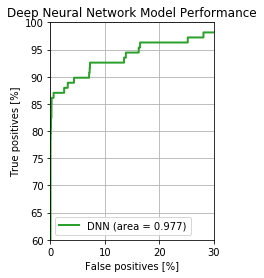

In [11]:
fpr_DNN, tpr_DNN, thresholds_DNN = roc_curve(Y_test, y_pred_DNN)
auc_DNN = auc(fpr_DNN, tpr_DNN)

plt.plot(100*fpr_DNN, 100*tpr_DNN, label= 'DNN (area = {:.3f})'.format(auc_DNN), linewidth=2, color = colors[2])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Deep Neural Network Model Performance')
plt.legend(loc='best')

### Fit Isolation Forest

In [12]:
iforest = IsolationForest()
iforest.fit(X_train)

y_pred_iforest = - iforest.decision_function(X_test)

### Evaulate Performance

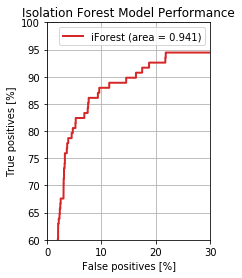

In [13]:
fpr_iforest, tpr_iforest, thresholds__iforest = roc_curve(Y_test, y_pred_iforest)
auc_iforest = auc(fpr_iforest, tpr_iforest)

plt.plot(100*fpr_iforest, 100*tpr_iforest, label= 'iForest (area = {:.3f})'.format(auc_iforest), linewidth=2, color = colors[3])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Isolation Forest Model Performance')
plt.legend(loc='best')

### Compare performance across all models

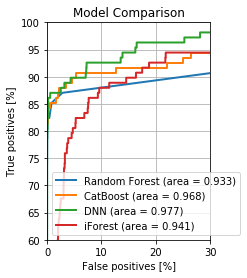

In [14]:
plt.plot(100*fpr_rf, 100*tpr_rf, label= 'Random Forest (area = {:.3f})'.format(auc_rf), linewidth=2, color = colors[0])
plt.plot(100*fpr_cat, 100*tpr_cat, label= 'CatBoost (area = {:.3f})'.format(auc_cat), linewidth=2, color = colors[1])
plt.plot(100*fpr_DNN, 100*tpr_DNN, label= 'DNN (area = {:.3f})'.format(auc_DNN), linewidth=2, color = colors[2])
plt.plot(100*fpr_iforest, 100*tpr_iforest, label= 'iForest (area = {:.3f})'.format(auc_iforest), linewidth=2, color = colors[3])
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([0,30])
plt.ylim([60,100])
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
plt.title('Model Comparison')
plt.legend(loc='best')